It would look neat with two cells, left pi/tajD and right roh with the roh legend at the side, however I think ibd is worth mentioning as it wasn't applied to all pops in the phase 1 paper - so

four cells > TR=pi, TL=Tajd, BR=ibd, BL=roh/legend

In [27]:
%run setup.ipynb
from itertools import combinations
from intervaltree import Interval, IntervalTree
from pathlib import Path
import logging
LOGFORMAT = '%(asctime)s : %(levelname)s : %(message)s'
logging.basicConfig(format=LOGFORMAT, level=logging.INFO, datefmt="%Y-%m-%d %H:%M:%S")
populations = phase2_ar1.pop_ids
pop_colours = phase2_ar1.pop_colors
pop_labels = phase2_ar1.pop_labels

# setup pi and taj'D

In [2]:
winsize = '20000'
chrom = '3R'
start = 1000000
stop = 37000000
pi_fn = '../phase2.AR1/extras/diversity/pi.windows_eqaccess.h5'
pi = h5py.File(pi_fn, 'r')
td_fn = '../phase2.AR1/extras/diversity/Tajimas_D.windows_eqaccess.h5'
td = h5py.File(td_fn, 'r')

In [3]:
#make boolean to compress to accessible region
pia = pi[winsize][chrom]['AOcol']['windows'][:]
tda = td[winsize][chrom]['AOcol']['windows'][:]
geoff = (pia[:,0] > start) & (pia[:,1] < stop)
pia.shape, geoff.shape

((1621, 2), (1621,))

In [4]:
#make dict of acc region pi to boxplot
div_dic = {}
taj_dic = {}
for pop in populations:
    pi_all = pi[winsize][chrom][pop]['pi'][:]
    td_all = td[winsize][chrom][pop]['tajd'][:]
    div_dic[pop] = pi_all.compress(geoff, axis=0)
    taj_dic[pop] = td_all.compress(geoff, axis=0)

In [5]:
def pi_plot(ax=None):
    fig = plt.figure(1, figsize=(10, 2.5))

    # Create an axes instance
    if ax == None:
        ax = fig.add_subplot(111)
    sns.despine(ax=ax, offset=5)
    # Create the boxplot
    lw=0.7
    bp = ax.boxplot(x=[div_dic[pop] for pop in populations],
            labels=populations,  patch_artist=True, 
            medianprops={"color":"k", "linewidth":lw},
            whiskerprops={"color":"k"}, 
            capprops={"color":"k"},
            showfliers=False,
            flierprops={"c":"k", "markersize":0.7})

    for p in populations:
        plt.xticks(rotation='vertical')

    plt.ylabel(r'$\pi$', rotation = 0, fontsize=12)
    plt.xlabel('population', va='top')
    plt.ylim(0,0.021)

    for patch, color in zip(bp['boxes'], [pop_colours[pop] for pop in populations]):
        patch.set_color('k')
        patch.set_facecolor(color)
        patch.set_linewidth(lw)
        
def taj_plot(ax=None):
    # Create a figure instance
    fig = plt.figure(1, figsize=(10, 2.5))
    # Create an axes instance
    if ax == None:
        ax = fig.add_subplot(111)
    sns.despine(ax=ax, offset=5)
    # Create the boxplot
    lw=0.7
    bp = ax.boxplot(x=[taj_dic[pop] for pop in populations],
            labels=populations,  patch_artist=True, 
            medianprops={"color":"k", "linewidth":lw},
            whiskerprops={"color":"k"}, 
            capprops={"color":"k"},
            showfliers=False,
            flierprops={"c":"k", "markersize":0.7})

    for p in populations:
        plt.xticks(rotation='vertical')

    plt.ylabel(r"Tajima's D", fontsize=12)
    plt.xlabel('population', va='top')

    for patch, color in zip(bp['boxes'], [pop_colours[pop] for pop in populations]):
        patch.set_color('k')
        patch.set_facecolor(color)
        patch.set_linewidth(lw)

# setup ibd

In [28]:
marker_style = {
    'GHcol' : 'D',
    'GHgam' : 'o',
    'BFgam' : 'o',
    'BFcol' : 'D',
    'UGgam' : 'o',
    'GM' : '*',
    'GW' : '*',
    'KE' : '*',
    'CMgam' : 'o',
    'FRgam' : 'o', 
    'GQgam' : 'o', 
    'AOcol' : 'D', 
    'GAgam' : 'o', 
    'GNgam' : 'o', 
    'GNcol' : 'D', 
    'CIcol' : 'D'
}

regions = {
    "3R": (1000000, 37000000),
    "3L": (15000000, 41000000)}
seqs = sorted(regions.keys())
starts = [regions[c][0] for c in seqs]
ends = [regions[c][1] for c in seqs]

# need to download this file to run!

In [ ]:
ibd_data = Path("/kwiat/vector/ag1000g/analysis/20180625-IBD-phase2", "output")

# plot

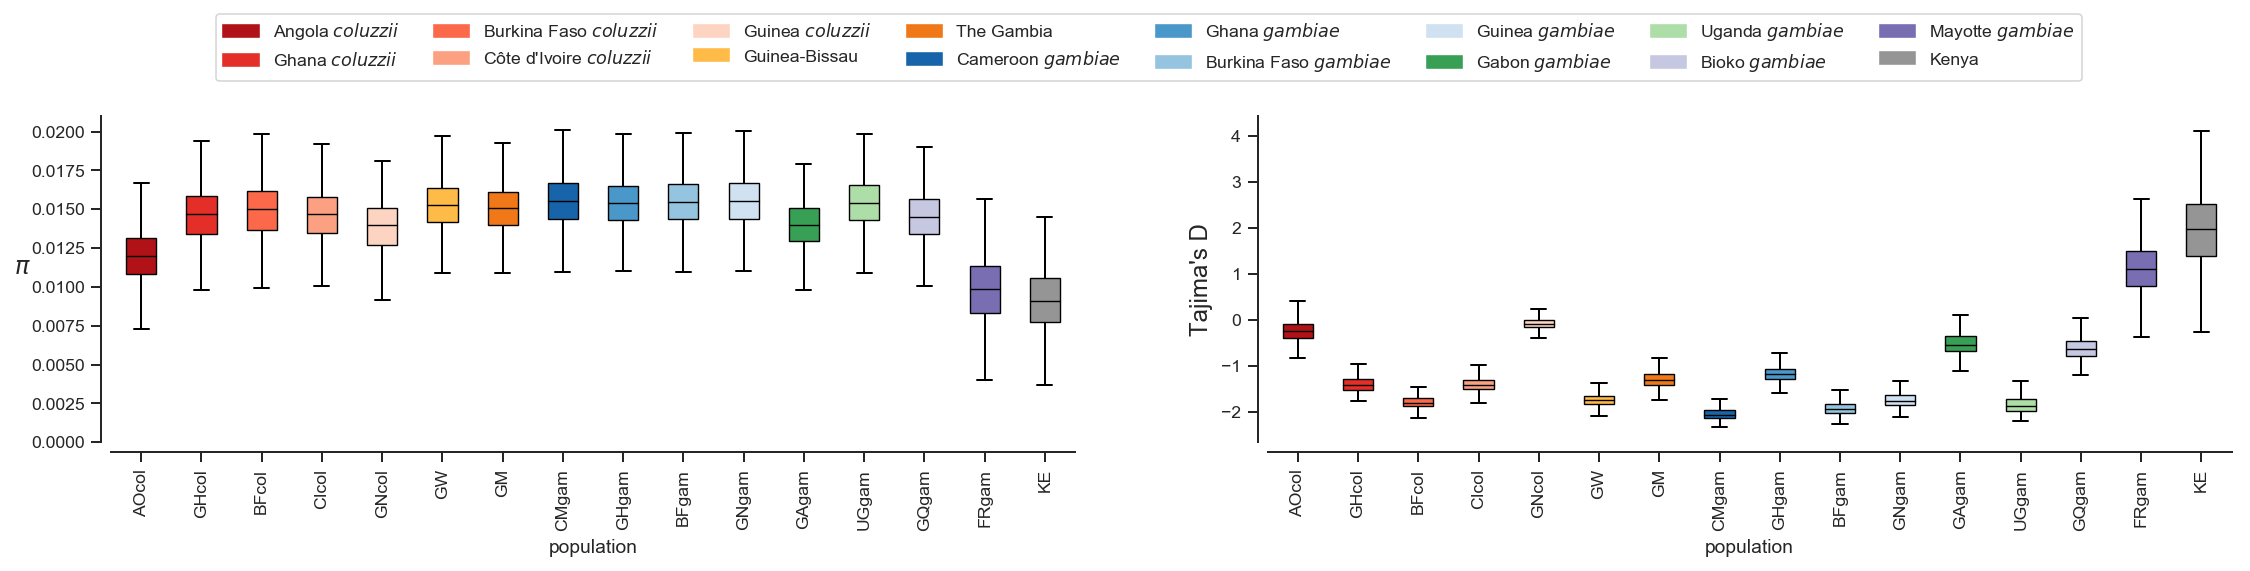

In [24]:
# create the figure
fig = plt.figure(figsize=(19, 3))

# define subplot layout
gs_nrows = 1
gs_ncols = 2
gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols)
ax1 = plt.subplot(gs[0])
pi_plot(ax1)
ax2 = plt.subplot(gs[1])
taj_plot(ax2)

handles = [mpl.patches.Patch(color=pop_colours[pop], label=pop_labels[pop]) for pop in populations]
plt.legend(handles=handles, loc='lower left', bbox_to_anchor=(-1.1, 1.08), ncol=8);